# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [291]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt

Now you can load the data:

In [292]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

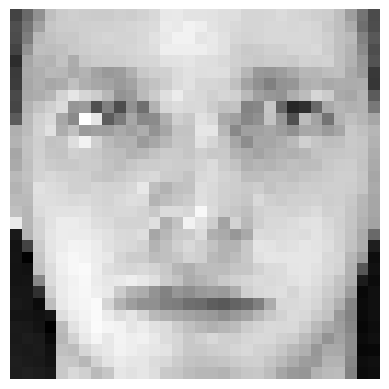

In [293]:
# Display a single example.
show_single_face(data[0, :])

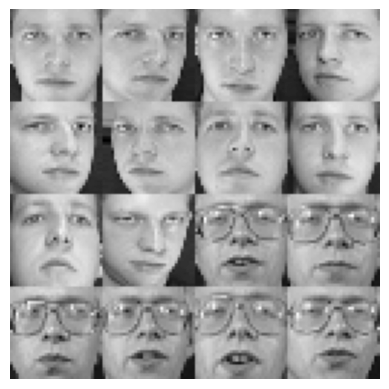

In [294]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [295]:
# normalization
data = data / 255

# partition
def split_data(data, num_per_class):
    tr_ind, te_ind = partition_data(labels, num_per_class)
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    return tr_data, tr_label, te_data, te_label

tr_data, tr_label, te_data, te_label = split_data(data, 3)  

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [296]:
def l2_rls_train(data, labels, lmbd): # Add any other arguments here
    """
    This function is implementing the L2-regularized least squares regression algorithm for training a linear regression model. 

    data: a numpy array of shape (n_samples, n_features) containing the input data.
    labels: a numpy array of shape (n_samples,) containing the output labels.
    lmbd: a float representing the regularization parameter.

    Returns: coefficient vector w.
    w = (X!^T * X! + λI)^ -1 * X!^T * Y
    """  
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(X.shape[0],dtype =int), X]
    
    # Compute the optimal weight vector.
    # Check whether the regularization parameter is greater than 0
    # Ridge regression (or Tikhonov regularization)
    if lmbd > 0:
        I_matrix = np.identity(X.shape[1]+1)    # the identity matrix with shape (X.shape[1] + 1, X.shape[1] + 1)
        first = X_tilde.T @ X_tilde     # the dot product of the transpose of the input data matrix X
        second = lmbd * I_matrix    # λ*I
        third = X_tilde.T @ np.array(y)     # the dot product of the transpose of X_tilde with the output labels y
        
        # print(np.linalg.inv((X_tilde.T@X_tilde) + (hyperparameter*I_matrix)))
        # Compute the (multiplicative) inverse of a matrix
        w = (np.linalg.inv(first + second))@ third
    
    # Use the pseudo-inverse of X_tilde multiplied with the output labels y. (no regularization is applied.)
    elif lmbd == 0:
        w = np.linalg.pinv(X_tilde) @ y
    
    return w

In [297]:
l2_rls_train(tr_data,tr_label,0)

array([ 1.30363522e+01, -3.32000996e+00, -2.63979531e+00, -2.15055075e+00, -4.12769189e-01,  4.10495341e-01, -1.97920975e-02,  1.59358464e-01, -3.66734732e-01, -1.90428857e-01, -5.12866566e-01, -1.48755560e+00, -2.23945557e+00, -2.70452167e+00, -1.71056737e+00, -2.81282229e+00, -2.60064936e+00, -2.09399419e+00, -5.79877407e-01,  8.78864109e-03, ..., -1.14615763e+00, -1.48133325e+00, -2.47353069e+00, -7.93338852e-01,  1.20874484e+00, -3.22638565e-01, -5.07017507e-01, -8.99145883e-01, -1.05257360e+00, -1.19433620e+00, -1.63962354e-01,  2.72848485e-01,  2.67328028e+00,  1.23844513e+00, -1.15565456e+00, -1.74694556e-01, -1.72346317e+00, -1.50519787e+00, -8.28288242e-01, -1.10535790e+00])

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [298]:
def l2_rls_predict(w, data):
    """
    This is a function for making predictions using a trained L2-regularized least squares regression model. 
    
    data: the input data for which we want to make predictions.
    w: the coefficient vector (including the bias term) learned by the l2_rls_train.

    Returns: the vector of predicted outputs for the input data.
    """ 
    # This is just to be consistent with the lecture notes.
    X = data  
    
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(X.shape[0]),X]
    
    # Compute the prediction.
    predicted_y = X_tilde @ w
    
    return predicted_y

In [299]:
l2_rls_predict(l2_rls_train(tr_data,tr_label,2),te_data)

array([ 9.07836756,  8.96782016,  2.68848563, 21.66158277, 22.31399903, 16.37028527, 23.65116107, 15.26406597, 18.44643103,  5.12408833,  8.29242148, 12.52753959, 20.43140934, 22.07588021, 28.47535571, 29.1858464 , 24.63042091, 14.81515199, 20.98283347, 20.17648574, 14.54686325, 11.43847675, 13.52017283, 14.34964684, 16.48322575, 14.64723812,  8.50866789, 13.8258111 , 16.95339743, 24.46854209, 10.31762327, 15.29475185, 18.81231117, 13.7440665 , 21.6651106 , 28.40635657, 24.70977271, 24.54981386, 20.0467897 , 15.95097106, 18.42486583, 14.08148778, 13.48034099, 19.18944884, 16.1226594 , 14.07489714, 22.51727527, 11.98855806, 29.39518317, 17.29608764, 14.26170089, 20.44563282, 15.50000817, 17.22161553, 22.77688866, 23.29413507, 16.9457925 , 23.82703074, 16.81949994, 11.19178929, 16.58687583, 14.38934224, 17.37154775, 12.40073716, 12.01196364, 10.83362494,  5.99002472,  4.16447024,  9.68775549, 25.89755631, 13.34081191, 17.37974405, 18.40547806, 16.85842255, 20.16842075, 15.91674033,
     

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [300]:
# 暂时不用

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from random import sample

def onehot_encoding_multi(labels_encoded):
    ''' 
    One-hot encoding function for a labels vector

    labels_encoded: an array which contains labels

    returns: 2 new vectors with full numbers describing futures
    '''
    # Convert features to a list of numbers e.g.: 1,2,3,4
    integer = LabelEncoder().fit_transform(labels_encoded)
    
    # Convert a column of text data into one or more columns of data represented only by 0 and 1, e.g.: 001,100,010
    integer2 = integer.reshape(len(integer), 1)
    onehot_labels = OneHotEncoder(sparse_output=False).fit_transform(integer2)

    return onehot_labels

# Encode labels using one-hot encoding
le = LabelEncoder()
tr_label_encoded = le.fit_transform(tr_label)
te_label_encoded = le.transform(te_label)
enc = OneHotEncoder(categories='auto')
tr_label_onehot = enc.fit_transform(tr_label_encoded.reshape(-1, 1)).toarray()
te_label_onehot = enc.transform(te_label_encoded.reshape(-1, 1)).toarray()


# a set of lambdas for testing (10-(-5)) / 0.375 = 40
base_set = np.arange(start=-5, stop=2, step=0.375)
hyper_set = [10 ** base for base in base_set]
lambdas = np.array(hyper_set)
print("Lambdas:", lambdas)

# Number of times to test for each lambda
testing_number = 5

# create 2 lists for saving
accuracy = np.zeros(shape=(len(lambdas),testing_number))
errors = np.zeros(shape=(len(lambdas),testing_number))

Lambdas: [1.00000000e-05 2.37137371e-05 5.62341325e-05 1.33352143e-04 3.16227766e-04 7.49894209e-04 1.77827941e-03 4.21696503e-03 1.00000000e-02 2.37137371e-02 5.62341325e-02 1.33352143e-01 3.16227766e-01 7.49894209e-01 1.77827941e+00 4.21696503e+00 1.00000000e+01 2.37137371e+01 5.62341325e+01]


In [301]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Split data into training and test sets: 5 and 5 
# The training set contains 5 randomly selected images per subject and the test set contains the remaining images
tr_ind, te_ind = partition_data(labels, 5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# Encode labels using one-hot encoding
le = LabelEncoder()
tr_label_encoded = le.fit_transform(tr_label)
te_label_encoded = le.transform(te_label)
print(te_label_encoded)
enc = OneHotEncoder(categories='auto')
tr_label_onehot = enc.fit_transform(tr_label_encoded.reshape(-1, 1)).toarray()
te_label_onehot = enc.transform(te_label_encoded.reshape(-1, 1)).toarray()

# Define hyperparameters for L2 regularization
# lmbd_values = np.logspace(-3, 3, num=7)
# a set of lambdas for testing (10-(-5)) / 0.375 = 40
base_set = np.arange(start=-5, stop=10, step=0.375)
hyper_set = [10 ** base for base in base_set]
lambdas = np.array(hyper_set)
lmbd_values = lambdas

# Initialize variables for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
best_lmbd = None
best_acc = 0

# Loop over hyperparameters and perform k-fold cross-validation to select the best one
for lmbd in lmbd_values:
    acc = 0
    for tr_idx, val_idx in kf.split(tr_data):
        # Split data into training and validation sets
        tr_data_fold = tr_data[tr_idx]
        tr_label_fold = tr_label_onehot[tr_idx]
        val_data_fold = tr_data[val_idx]
        val_label_fold = tr_label_onehot[val_idx]
        
        # Train model using L2-regularized least squares regression
        w = l2_rls_train(tr_data_fold, tr_label_fold, lmbd)
        
        # Make predictions on validation set
        pred = np.argmax(l2_rls_predict(w, val_data_fold), axis=1)
        true = np.argmax(val_label_fold, axis=1)
        
        # Compute accuracy of predictions on validation set
        acc += accuracy_score(true, pred)
    
    # Average accuracy over k folds
    acc /= k
    
    # Update best hyperparameter if necessary
    if acc > best_acc:
        best_lmbd = lmbd
        best_acc = acc

# Train final model using best hyperparameter on entire training set
w = l2_rls_train(tr_data, tr_label_onehot, best_lmbd)

# Make predictions on test set
pred = np.argmax(l2_rls_predict(w, te_data), axis=1)
true = te_label_encoded 

# Compute confusion matrix and overall accuracy on test set
cm = confusion_matrix(true, pred, labels=np.arange(40))
acc = accuracy_score(true, pred)

print("Confusion matrix: \n",cm)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39 39 39 39]
Confusion matrix: 
 [[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [302]:
# lmbd_values = np.logspace(-3, 3, num=7)
print(lmbd_values)
print(acc)
print(best_lmbd)
print(pred)

[1.00000000e-05 2.37137371e-05 5.62341325e-05 1.33352143e-04 3.16227766e-04 7.49894209e-04 1.77827941e-03 4.21696503e-03 1.00000000e-02 2.37137371e-02 5.62341325e-02 1.33352143e-01 3.16227766e-01 7.49894209e-01 1.77827941e+00 4.21696503e+00 1.00000000e+01 2.37137371e+01 5.62341325e+01 1.33352143e+02 3.16227766e+02 7.49894209e+02 1.77827941e+03 4.21696503e+03 1.00000000e+04 2.37137371e+04 5.62341325e+04 1.33352143e+05 3.16227766e+05 7.49894209e+05 1.77827941e+06 4.21696503e+06 1.00000000e+07 2.37137371e+07 5.62341325e+07 1.33352143e+08 3.16227766e+08 7.49894209e+08 1.77827941e+09 4.21696503e+09]
0.955
0.7498942093324559
[ 0  0  0  0 23  1  1  1  1  1  2  2  2  2  2  3 39  3  3  3  4  4  4  4  4  5  5  5  5  5  6  6  6  6  6  7  7  7  2  7  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 11 11 11 11 11 12 12  0  5 12 13 13 13 13 13 14 14 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 20 19 20 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

[40.0, 6.0, 5.0]


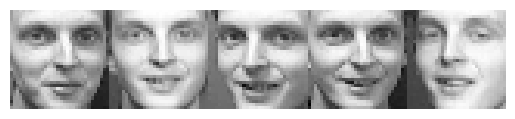

In [303]:
true, predicted = np.array_split(true, 40), np.array_split(pred, 40)
difficulty_list = np.zeros(shape=(len(true), 2))

for i in range(len(true)):
    difficulty_list[i][0]=i+1
    difficulty_list[i][1]=np.sum(true[i]==predicted[i])

# The classes with the highest error rates locates at the beginning
# And the classes with the lowest error rates or none locates at the end
difficulty_list = difficulty_list[difficulty_list[:,1].argsort()]

easier_samples = []
easier_samples.append(difficulty_list[len(difficulty_list)-1][0])
easier_samples.append(difficulty_list[len(difficulty_list)-2][0])
easier_samples.append(difficulty_list[len(difficulty_list)-3][0])

print(easier_samples)
show_faces(te_data[:int(easier_samples[0])*5][int(easier_samples[0])*5-5:], num_per_row=5)

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

[20.0, 13.0, 26.0]


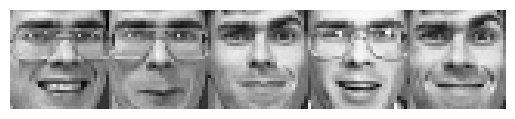

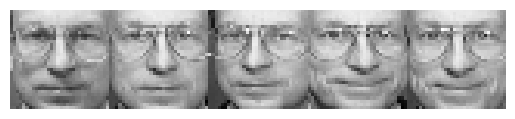

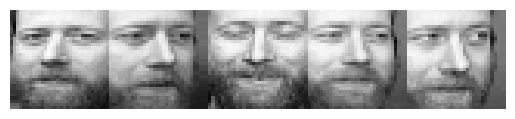

In [304]:
harder_samples = []
harder_samples.append(difficulty_list[0][0])
harder_samples.append(difficulty_list[1][0])
harder_samples.append(difficulty_list[2][0])

print(harder_samples)
show_faces(te_data[:int(harder_samples[0])*5][int(harder_samples[0])*5-5:], num_per_row=5)
show_faces(te_data[:int(harder_samples[1])*5][int(harder_samples[1])*5-5:], num_per_row=5)
show_faces(te_data[:int(harder_samples[2])*5][int(harder_samples[2])*5-5:], num_per_row=5)

### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [305]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

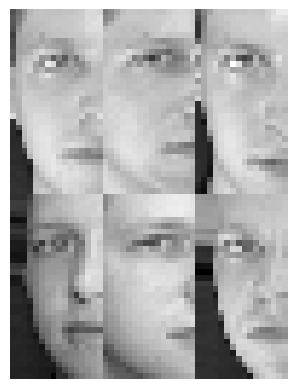

In [306]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [307]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
# Separate the training data and test data into left and right
left_tr_data, left_te_data = left[tr_ind, :], left[te_ind, :]
right_tr_data, right_te_data = right[tr_ind, :], right[te_ind, :]

# Train the data to understand the right side as a weighted output of the left side pixels and predict it 
y_predict = l2_rls_predict(l2_rls_train(left_tr_data,right_tr_data, 0),left_te_data)
    
MAPE = np.mean(abs(right_te_data - y_predict) / abs(right_te_data))
print("MAPE:", MAPE)

MAPE: 0.21213304864702803


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

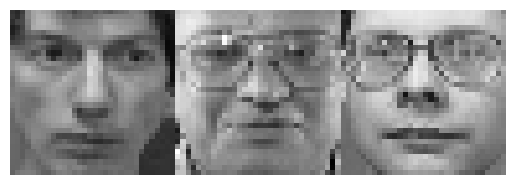

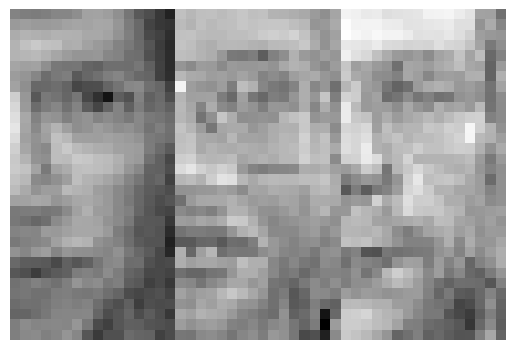

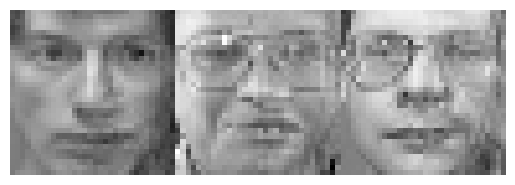

In [308]:
import random
random_number= random.sample(range(0,279),3)
predict_face = join_left_right(left_te_data,y_predict)
origin_Face= data[te_ind,:]

show_faces(origin_Face[random_number],num_per_row = 3)
show_split_faces(y_predict[random_number], num_per_row = 3)
show_faces(predict_face[random_number],num_per_row = 3)

### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [309]:
def lls_gd_train(data, labels, N, learning_rate # Add any other arguments here if needed
          ):
    """
    This function trains a single-output linear model by minimising the sum of squares loss
    using the gradient descent approach and calculate the weights and the costs

    data: array which store the training data in the form of matrix.
    labels: array which store the class that the training data belongs to in the form of matrix.
    N: the number of iterations to run the gradient descent for.
    learning_rate α: the learning rate to use for the gradient descent updates.

    Returns: 
    cost_all - costs of the linear least squares calculated
    w_all - weights of the linear least squares calculated
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(X.shape[0], dtype =int),X]

    # Weight initialization
    w = np.zeros(X.shape[1]+1)

    # Initialise arrays to store weights and cost at each iteration
    w_all = []
    cost_all = []
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        gd = (X_tilde.T @ X_tilde @ w) - (X_tilde.T @ y)
        cost = np.sum(np.square((y- X_tilde@w)))/2

        # Weight update
        w = w - (learning_rate * gd)
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all

In [310]:
# This is a test
x =np.array([[36,50],[70,20],[35, 85],[20,11]])
y = np. array([60,128,22,37])
n =5
lm = 0.0001
lls_gd_train(x,y,n,lm)

([10918.5,
  4541.325757889999,
  2089.1983495973077,
  1060.7872819359723,
  591.2475178367699],
 [array([0.0247, 1.263 , 0.7837]),
  array([ 0.0160464 ,  1.03663388, -0.04367754]),
  array([0.02477522, 1.51655596, 0.12158073]),
  array([ 0.02303052,  1.51530779, -0.18953969]),
  array([ 0.02647121,  1.71402541, -0.18105896])])

### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

In [311]:
# Your code goes here
def clarify_subject_1_30(data):
    tr_data, tr_label, te_data, te_label = split_data(data, 3)  
    tr_data2 = tr_data[np.where((tr_label==1) | (tr_label==30))]
    te_data2 = te_data[np.where((te_label==1) | (te_label==30))]
    tr_label2 = tr_label[np.where((tr_label==1) | (tr_label==30))]
    te_label2 = te_label[np.where((te_label==1) | (te_label==30))]
    return tr_data2, tr_label2, te_data2, te_label2

In [312]:
tr_data2, tr_label2, te_data2, te_label2 = clarify_subject_1_30(data)

learning_rate = 10**(-3)
N = 200

cost_all, w_all = lls_gd_train(tr_data2, tr_label2, N, learning_rate)
print(cost_all,"\n", w_all)

[1351.5, 1178.6004092043975, 1040.378573301445, 928.8606937657768, 837.9614287474568, 763.0340112836965, 700.5276653030131, 647.7267228519603, 602.5519524725723, 563.4092583345737, 529.0744501336384, 498.6054795433224, 471.27559165684556, 446.5224028064016, 423.909106228826, 403.0949132127112, 383.8125273467924, 365.85097486689443, 349.0425141391231, 333.2526519218325, 318.37252598614145, 304.31309028060866, 291.00067330040156, 278.37358271606524, 266.3795072850052, 254.97352643748957, 244.11658313548412, 233.7743100255841, 223.916125119255, 214.5145331933671, 205.54458430315537, 196.98345237391482, 188.81010565172016, 181.0050475056933, 173.5501111861867, 166.42829603647039, 159.62363562079008, 153.12109049034063, 146.90646002930268, 140.96630913396555, 135.28790647679645, 129.85917186855482, 124.66863081181222, 119.70537478168995, 114.95902610710442, 110.41970658333771, 106.07800914336937, 101.9249720656223, 97.9520553106424, 94.15111866714886, 90.51440145527948, 87.03450358657491, 8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


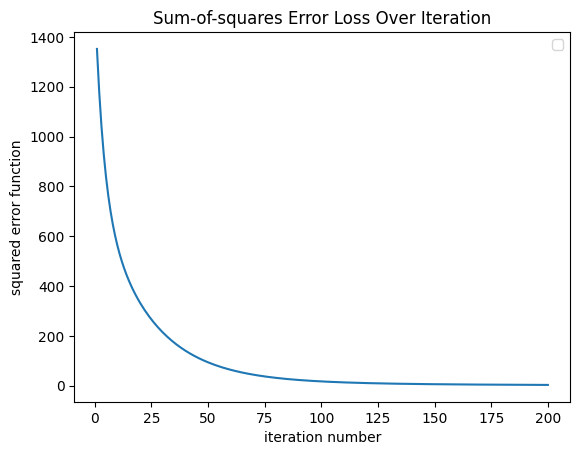

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


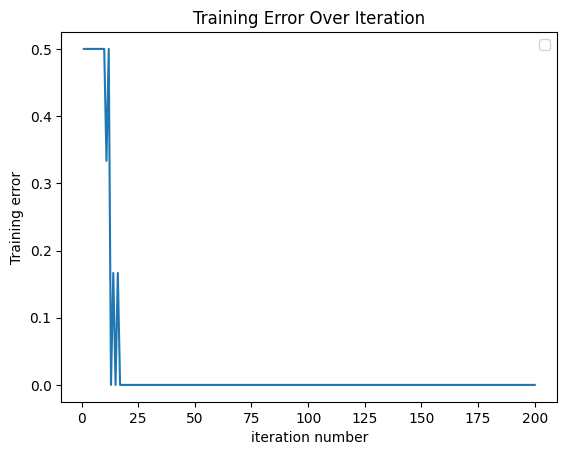

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


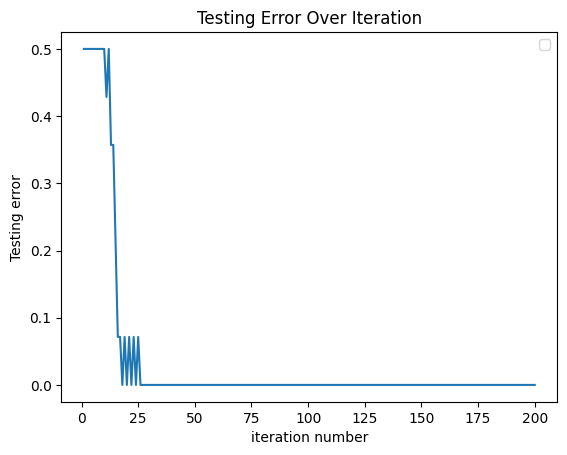

In [313]:
# The change of your sum-of-squares error loss that you minimise (1st graph)
datum = np.arange(1, 201, 1)
plt.plot(datum, cost_all,label='')
plt.xlabel('iteration number')
plt.ylabel('squared error function')
plt.title('Sum-of-squares Error Loss Over Iteration')
plt.legend()
plt.show()

def predictgd(w, te_data2, te_label2):
    correct = 0
    y = l2_rls_predict(w, te_data2)
    for i in range(len(y)):
        if y[i] < 15.5:
            y[i] = 1
        else:
            y[i] = 30
        if y[i] == te_label2[i]:
            correct += 1
    len_te_label2 = len(te_label2)
    error = (len_te_label2 - correct)/len_te_label2
    return error

# the change of the classification accuracy for training samples over iterations (2rd graph)
errorListGdTrain = []
for i in w_all:
    error = predictgd(i, tr_data2, tr_label2)
    errorListGdTrain.append(error)

datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTrain,label='')
plt.xlabel('iteration number')
plt.ylabel('Training error')
plt.title('Training Error Over Iteration')
plt.legend()
plt.show()

# the change of the classification accuracy for test samples over iterations (3rd graph)
errorListGdTest = []
for i in w_all:
    error = predictgd(i, te_data2, te_label2)
    errorListGdTest.append(error)

    datum = np.arange(1, 201, 1)
plt.plot(datum, errorListGdTest)
plt.xlabel('iteration number')
plt.ylabel('Testing error')
plt.title('Testing Error Over Iteration')
plt.legend()
plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

In [314]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
tr_data2, tr_label2, te_data2, te_label2 = clarify_subject_1_30(data)
learning_rate = 10**(-2)
N = 200

cost_all, w_all = lls_gd_train(tr_data2, tr_label2, N, learning_rate)

cost_all = np.array(cost_all).reshape(-1,1)
# # scaler = MinMaxScaler()
# # cost_all = scaler.fit_transform(cost_all)
# # transformer = Normalizer().fit(cost_all)
# # transformer.transform(cost_all)
# cost_all = np.array(cost_all).reshape(-1,1)

# # scale cost_all to be between 0 and 1
# scaler = MinMaxScaler()
# cost_all = scaler.fit_transform(cost_all)

# # normalize the scaled cost_all using Normalizer
# transformer = Normalizer().fit(cost_all)
# transformer.transform(cost_all)
print(cost_all,"\n", w_all)

[[1.35150000e+003]
 [1.61917973e+005]
 [4.70454701e+007]
 [1.37103370e+010]
 [3.99559270e+012]
 [1.16443245e+015]
 [3.39349635e+017]
 [9.88963978e+019]
 [2.88212996e+022]
 [8.39936874e+024]
 [2.44782144e+027]
 [7.13366683e+029]
 [2.07895893e+032]
 [6.05869370e+034]
 [1.76568035e+037]
 [5.14570840e+039]
 [1.49960976e+042]
 [4.37030097e+044]
 [1.27363338e+047]
 [3.71173978e+049]
 [1.08170941e+052]
 [3.15241725e+054]
 [9.18706487e+056]
 [2.67737911e+059]
 [7.80266493e+061]
 [2.27392452e+064]
 [6.62688039e+066]
 [1.93126655e+069]
 [5.62827497e+071]
 [1.64024376e+074]
 [4.78014952e+076]
 [1.39307522e+079]
 [4.05982820e+081]
 [1.18315255e+084]
 [3.44805219e+086]
 [1.00486314e+089]
 [2.92846478e+091]
 [8.53440193e+093]
 [2.48717406e+096]
 [7.24835185e+098]
 [2.11238149e+101]
 [6.15609682e+103]
 [1.79406647e+106]
 [5.22843383e+108]
 [1.52371837e+111]
 [4.44056049e+113]
 [1.29410906e+116]
 [3.77141188e+118]
 [1.09909961e+121]
 [3.20309736e+123]
 [9.33476152e+125]
 [2.72042223e+128]
 [7.92810515

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/rm/zkx7tx614cq0pcwp0cpgbhy80000gn/T/ipykernel_2746/2606674007.py:34: RuntimeWarning: overflow encountered in square
  cost = np.sum(np.square((y- X_tilde@w)))/2


In [315]:
# Your code goes here
print(np.array(cost_all))

[[1.35150000e+003]
 [1.61917973e+005]
 [4.70454701e+007]
 [1.37103370e+010]
 [3.99559270e+012]
 [1.16443245e+015]
 [3.39349635e+017]
 [9.88963978e+019]
 [2.88212996e+022]
 [8.39936874e+024]
 [2.44782144e+027]
 [7.13366683e+029]
 [2.07895893e+032]
 [6.05869370e+034]
 [1.76568035e+037]
 [5.14570840e+039]
 [1.49960976e+042]
 [4.37030097e+044]
 [1.27363338e+047]
 [3.71173978e+049]
 [1.08170941e+052]
 [3.15241725e+054]
 [9.18706487e+056]
 [2.67737911e+059]
 [7.80266493e+061]
 [2.27392452e+064]
 [6.62688039e+066]
 [1.93126655e+069]
 [5.62827497e+071]
 [1.64024376e+074]
 [4.78014952e+076]
 [1.39307522e+079]
 [4.05982820e+081]
 [1.18315255e+084]
 [3.44805219e+086]
 [1.00486314e+089]
 [2.92846478e+091]
 [8.53440193e+093]
 [2.48717406e+096]
 [7.24835185e+098]
 [2.11238149e+101]
 [6.15609682e+103]
 [1.79406647e+106]
 [5.22843383e+108]
 [1.52371837e+111]
 [4.44056049e+113]
 [1.29410906e+116]
 [3.77141188e+118]
 [1.09909961e+121]
 [3.20309736e+123]
 [9.33476152e+125]
 [2.72042223e+128]
 [7.92810515

### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [316]:
# Your code goes here
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: array which store 1 training data in the form of matrix.
    labels: array which store the class that the training data belongs to in the form of matrix. label[i, :] stores the 
    class of data[i, :].
    
    Returns: 2 array. The first stores the cost of each iteration and the second store the weight vector of each iteration.
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    ncol = len(data)
    X_tilde = np.hstack((np.ones((ncol, 1), dtype=int), data))
    w = np.zeros(1025)
    
    # Get array of single data
    X_tilde = np.array([X_tilde[0]])
    y = np.array([y[0]])
    
    # GD update of weights
    cost_all = []
    w_all = []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        # (X.T@X)**(-1) @ X.T @ y
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        #cost = calcost(w, X_tilde, y)
        cost = 0.5 * np.sum((w @ X_tilde.T - y)**(2))
        # Weight update
        w = w - learning_rate * gd
        #print(cost)
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    
    # Return model parameters.
    return cost_all, w_all

### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


In [317]:
# Your code goes here

### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [318]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [319]:
# Your code goes here

### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**